In [382]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_pos_timestamp,get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

from spectral_connectivity.statistics import fisher_z_transform
from spectral_connectivity.statistics import coherence_bias

In [383]:
nwb_file_name = 'senor20201030_.nwb'

In [384]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_data = pd.read_csv(filename)
trial_data

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [385]:
#only look at one session 
trial_data_sesh = trial_data[trial_data.epoch==2]

In [386]:
#this will label trials where he is ABOUT to stem switch. the trial before stem switch, stem switch=true. 

trial_data_sesh['stem_switch'] = trial_data_sesh['stem'].ne(trial_data_sesh['stem'].shift())

for ix in range(len(trial_data_sesh)):
    if trial_data_sesh.loc[ix,'trial_number_by_epoch']==0:
        trial_data_sesh.loc[ix,'stem_switch']= True
trial_data_sesh['stem_switch']=trial_data_sesh['stem_switch'].shift(-1)        
trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [11]:
#now trial times only has stay trials

164

In [387]:
# theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])
lfp_timestamps, lfp_data, lfp_eseries = get_timestamps_and_data(nwb_file_name,data_type = ['lfp'])
theta_timestamps, theta_data, theta_eseries = get_timestamps_and_data(nwb_file_name,filter_type=['Theta 5-11 Hz'],data_type = ['theta'])


position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()

In [388]:
#This will find the length of the session by using the trial times in the data. probably not the best way to do this! how to grab the whole session times?

num_secs_to_get = int(trial_data_sesh.iloc[-1].poke_out_ts - trial_data_sesh.iloc[0].poke_in_ts-1)
num_secs_to_get

1144

In [389]:

num_secs_to_get = int(trial_data_sesh.iloc[-1].poke_out_ts - trial_data_sesh.iloc[0].poke_in_ts-1)


electrode_id = [8,17,40,132,244,300]
time_from_start = 0 #in seconds
time_interval_s = num_secs_to_get
sampling_rate_lfp = 1000
epoch = (IntervalList & {'nwb_file_name':nwb_file_name} & {'interval_list_name':'02_r1'}).fetch1('valid_times')
x_pos,y_pos = get_speed(position_info,epoch,time_from_start,time_interval_s)
x_elect_lfp, y_elect_lfp = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
x_elect_theta, y_elect_theta = get_x_y_list(time_from_start, time_interval_s,epoch, electrode_id, theta_eseries, theta_timestamps, theta_data)



In [1]:
#okay so now i have all of the data and trial times. 
#now i need to mask the lfp by chunks of time. Should start out with data that is the same size intstead of using trial times. 


In [390]:
trial_times=[]
for ix in range(len(trial_data_sesh)-1):
    if trial_data_sesh.iloc[ix].stem_switch == False:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch >=60:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch <60:
            # if trial_data_sesh.iloc[ix].stem == 'C':
        trial_start = trial_data_sesh.iloc[ix].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix+1].poke_in_ts
        if trial_end-trial_start<3:
            if trial_end-trial_start>2.1:
                trial_times.append([trial_start, trial_end])

Text(0, 0.5, 'len of trial (s)')

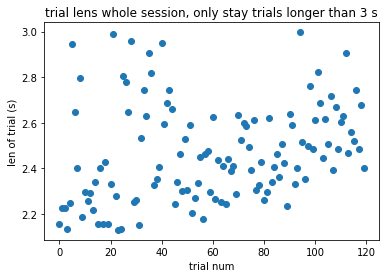

In [391]:
trial_lens=[]
for ix in range(len(trial_times)):
    trial_lens.append(trial_times[ix][1]-trial_times[ix][0])
plt.scatter(range(len(trial_lens)),trial_lens)
plt.title('trial lens whole session, only stay trials longer than 3 s') 
plt.xlabel('trial num')
plt.ylabel('len of trial (s)')

In [121]:
min_trial_len = min(trial_lens)
min_trial_len

n_trials = len(trial_lens)
n_signals= 2
n_time_samples = round((min_trial_len+.5)*sampling_rate_lfp)
signal = np.zeros((n_time_samples, n_trials, n_signals))

electrode_ix1 = 0
electrode_ix2 = 4

for trial in range(len(trial_times)):
    trial_start_time = trial_times[trial][0]
    trial_end_time = trial_start_time+min_trial_len+.5
    x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(trial_start_time, trial_end_time, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    time = x_elect_lfp_eg1[0]
    signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
    signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])


ValueError: could not broadcast input array from shape (2629,) into shape (2630,)

In [263]:
n_trials
signal.shape
#why os it longer than 2.5 seconds? 

(2630, 120, 2)

frequency resolution: 6.0


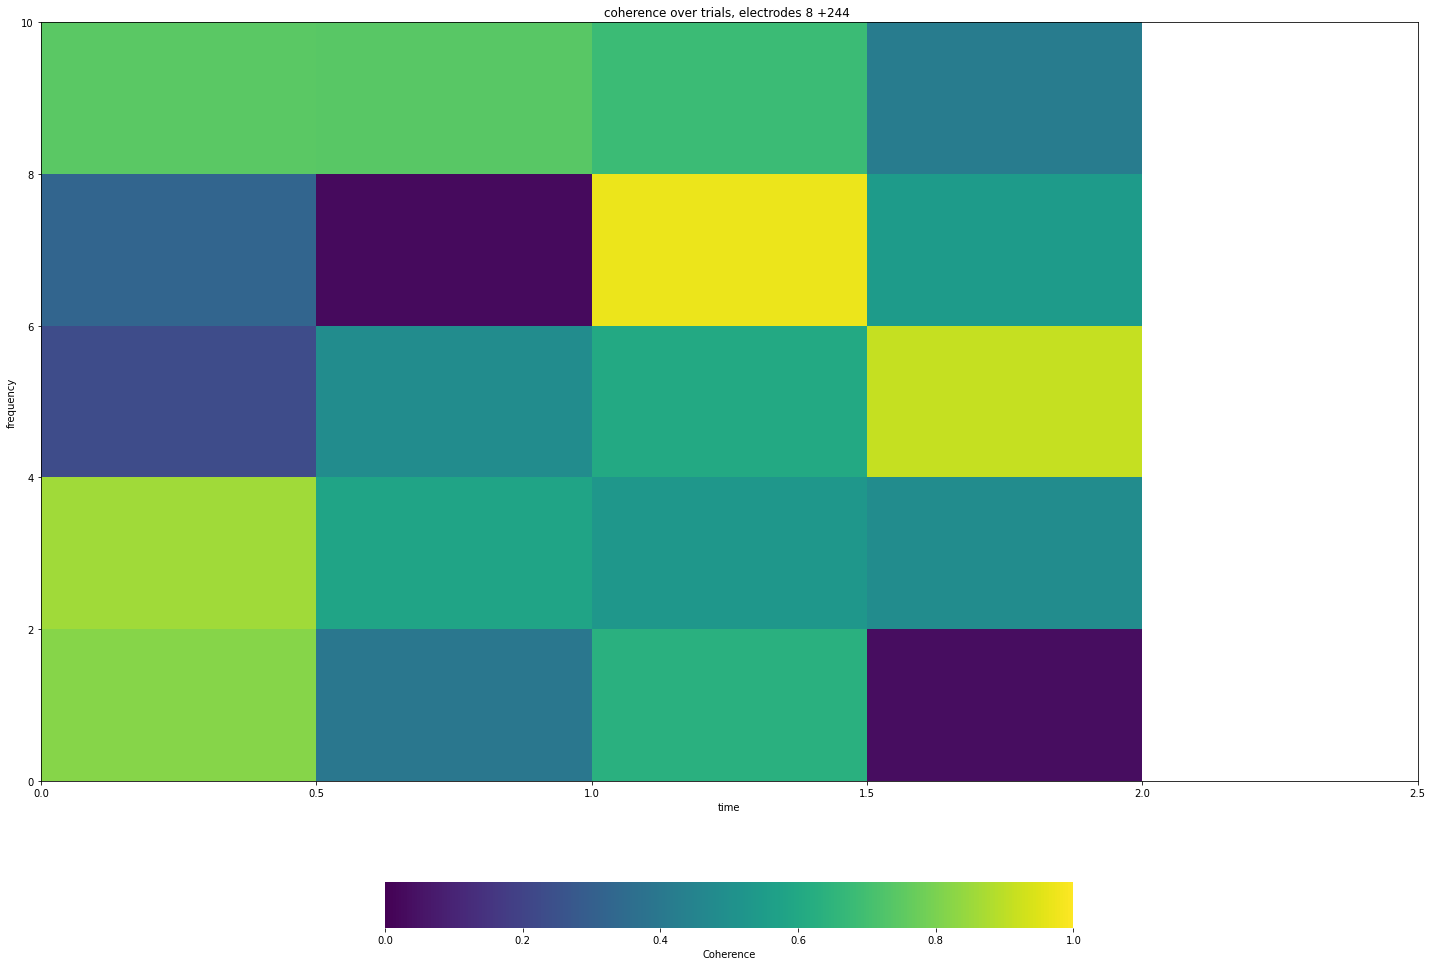

In [293]:
sampling_frequency=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_window_duration,
               time_window_step=time_window_step)
               # start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.ylim(0,10)
# plt.xlim(time_data[0],time_data[-1])
plt.title(f'coherence over trials, electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} ')
plt.xlim(0,2.5)

plt.tight_layout()
cb = plt.colorbar(mesh, orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb = plt.colorbar(mesh, ax.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
cb.outline.set_linewidth(0)
cb.outline.set_linewidth(0)
print('frequency resolution: {}'.format(m.frequency_resolution))
#maybe about two minutes

In [268]:
c.coherence_magnitude().shape#[..., 0, 1]).shape
m.nyquist_frequency

500.0

In [275]:
c.frequencies
freq_seg = c.frequencies[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coherency = c.coherency()[:, (c.frequencies == 8), 0, 1].squeeze()
coherency

array([ 0.31399895+0.803183j  ,  0.57937912+0.63745834j,
       -0.09219438+0.81978509j, -0.31954387+0.56090128j,
        0.54178131+0.07860407j])

In [272]:
c.coherency().shape

(5, 250, 2, 2)

Text(0, 0.5, 'coherence')

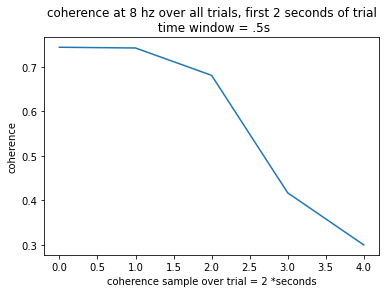

In [84]:

plt.plot(coh_seg[0])
plt.title('coherence at 8 hz over all trials, first 2 seconds of trial\n time window = .5s')
plt.xlabel('coherence sample over trial = 2 *seconds')
plt.ylabel('coherence')

In [276]:
bias1 = coherence_bias(c.n_observations)
bias1


0.0020920502092050207

In [284]:
z_transform= fisher_z_transform(coherency, bias1)

# What are these 
#heres what ive done 
#investigate what these dimensions are? 
#now if I want to get the error bars just around the 8hz  

#if i dont understand cohererncy vs magnitude and phase, ask loren! its his job. 


#goals: 
# - error bars
# edge effects? 
# (.) on github- IDE on the internet 
# maybe undertsnadnig the window 
#

In [222]:
num_tapers= m.n_tapers
num_trials = m.n_trials

In [285]:
z_transform

array([28.43229309, 28.35016817, 25.58073002, 16.73667437, 13.39440875])

In [235]:
z_transform

array([[28.43229309, 28.35016817, 25.58073002, 16.73667437, 13.39440875]])

Text(0, 0.5, 'z transform')

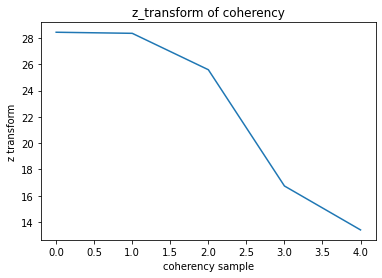

In [240]:
plt.plot(z_transform)
plt.title('z_transform of coherency')
plt.xlabel('coherency sample')
plt.ylabel('z transform')

In [367]:
coherency = c.coherency()[:, (c.frequencies == 8), 0, 1].squeeze()

bias1 = coherence_bias(c.n_observations)



z_transform= fisher_z_transform(coherency, bias1)



num_tapers= m.n_tapers
num_trials = m.n_trials


import math
ci_95_pos=[]
ci_95_neg=[]
for ix in range(len(z_transform)):
    z_ixed = z_transform[ix]
    ci_95_pos.append(z_ixed + 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    ci_95_neg.append(z_ixed - 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    # ci_95_pos.append(1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))
    # ci_95_neg.append(-1* 1.96 * math.sqrt(1 / (2 * (num_trials * num_tapers) -2)))




    

In [292]:
z_ixed

13.394408746129525

In [227]:
ci_95_pos

[28.52194139834971,
 28.4398164851378,
 25.670378334752915,
 16.826322685362307,
 13.48405705946381]

In [291]:
range(len(z_transform))
ci_95_neg

[28.342644771681144,
 28.260519858469234,
 25.491081708084348,
 16.64702605869374,
 13.30476043279524]

Text(0.5, 1.0, 'coherence with z transform +-std')

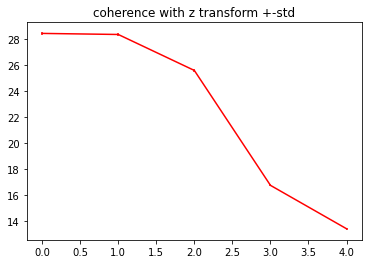

In [369]:
# plt.errorbar(range(len(z_transform)),coherency[0],
#             yerr=ci_95_pos,
#             fmt='-o')
# plt.title('coherence with z transform +-std')

#z transform so that they are more gaussian, because its easier to perform statistics on them

plt.errorbar(range(len(z_transform)),z_transform,
            yerr=ci_95_pos,
            color = 'r')
plt.title('coherence with z transform +-std')

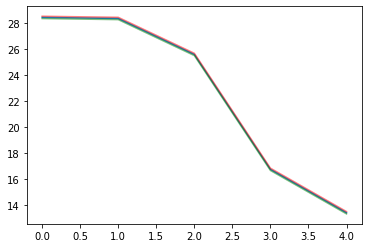

In [366]:
plt.plot(z_transform)
plt.plot(ci_95_pos, color='r', alpha=.5)
plt.plot(ci_95_neg,color='g', alpha=.5)

#make the error bars myself
#inverse fisher transform to get to the other domain
#cannonical coherence- group wise- using all electrodes- eaiser summary of things  

# plt.ylim(25,30)


In [ ]:
#hmmm so what should my next steps be? 
#I want to look at real trials but they need to be the same length. prioritize normalizing them? 

In [427]:
# Okay, lets try with two trials first. 

trial_data_sesh

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,80,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [392]:
trial_times=[]
for ix in range(len(trial_data_sesh)-1):
    if trial_data_sesh.iloc[ix].stem_switch == False:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch >=60:
        # if trial_data_sesh.iloc[ix].trial_number_by_epoch <60:
            # if trial_data_sesh.iloc[ix].stem == 'C':
        trial_start = trial_data_sesh.iloc[ix].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix+1].poke_in_ts
            # if trial_end-trial_start<3:
        trial_times.append([trial_start, trial_end])

In [428]:
from spyglass.common.common_position import (IntervalLinearizedPosition, IntervalPositionInfo, TrackGraph)

position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

linear_position_df= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_file_name,
                      'interval_list_name': 'pos 1 valid times',
                      'track_graph_name': 'senor20201030',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()
linear_position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.604079e+09,577.874670,5,94.909394,68.395049
1.604079e+09,575.946687,5,94.864057,70.322499
1.604079e+09,573.968992,5,94.817551,72.299647


In [416]:
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.604079e+09,96.2465,68.4265,1.892547,-18.510226,39.833951,43.924618
1.604079e+09,96.1395,70.3525,1.783228,-13.011806,39.301131,41.399107
1.604079e+09,96.1930,72.3320,1.723446,-8.684986,37.011240,38.016587


In [429]:
linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())

In [322]:
linear_position_df.iloc[0:100]

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
1.604078e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.604078e+09,186.385963,1,228.104765,131.958757
1.604078e+09,186.389935,1,228.108030,131.961017
1.604078e+09,186.393906,1,228.111296,131.963277


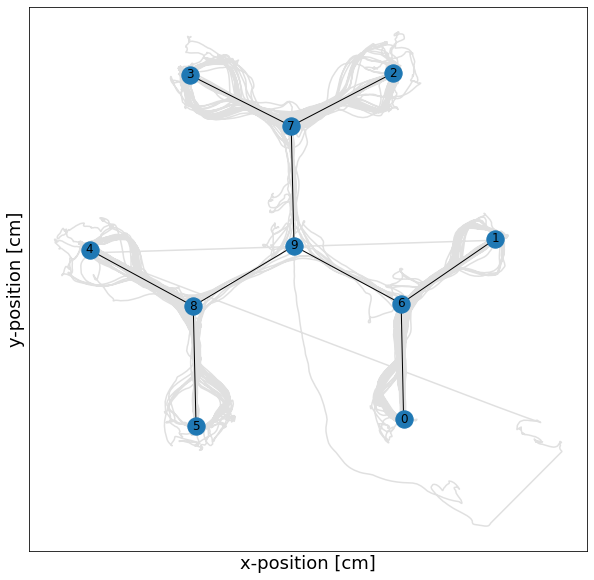

In [395]:
%matplotlib inline

graph = TrackGraph() & {'track_graph_name': 'senor20201030'}




fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_position_x, position_info.head_position_y,
        color='lightgrey', alpha=0.7, zorder=0)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
graph.plot_track_graph(ax=ax)

In [ ]:
#so the transitions I want are 4-8, 5-8; 0-6,1-6; 3-7,2-7; 

In [475]:
time_switch_seg = linear_position_df[linear_position_df['track_segment_id_switch']==1]
time_switch_seg

,linear_position,track_segment_id,projected_x_position,projected_y_position,track_segment_id_switch
time,,,,,
1.604078e+09,NaN,0,NaN,NaN,True
1.604078e+09,186.362136,1,228.085172,131.945197,True
1.604078e+09,40.299152,6,175.016305,111.195199,True
1.604078e+09,407.113984,8,139.369290,130.284822,True
1.604078e+09,488.345744,4,82.335145,109.494793,True
...,...,...,...,...,...
1.604079e+09,546.358726,5,94.168289,99.902278,True
1.604079e+09,476.652766,4,92.593767,103.883516,True
1.604079e+09,545.638869,5,94.151361,100.621936,True


In [476]:
time_switch_seg1 = time_switch_seg[time_switch_seg.track_segment_id !=6]
time_switch_seg1 = time_switch_seg1[time_switch_seg1.track_segment_id !=7]
time_switch_seg1 = time_switch_seg1[time_switch_seg1.track_segment_id !=8]
time_switch_seg1 = time_switch_seg1[time_switch_seg1.track_segment_id !=9]

In [477]:
time_switch_seg1

#need to figure out which semgnets are the same in 0-8. 
#look at beginning of linearization code. 

,linear_position,track_segment_id,projected_x_position,projected_y_position,track_segment_id_switch
time,,,,,
1.604078e+09,NaN,0,NaN,NaN,True
1.604078e+09,186.362136,1,228.085172,131.945197,True
1.604078e+09,488.345744,4,82.335145,109.494793,True
1.604078e+09,93.076683,0,188.440577,81.120332,True
1.604078e+09,342.414799,3,136.524766,185.815363,True
...,...,...,...,...,...
1.604079e+09,546.358726,5,94.168289,99.902278,True
1.604079e+09,476.652766,4,92.593767,103.883516,True
1.604079e+09,545.638869,5,94.151361,100.621936,True


In [500]:
times = time_switch_seg1.index

In [496]:
saving_ixes=[]
for ix in range(len(time_switch_seg1.index)):
    time = time_switch_seg1.index[ix]
    past_df = [linear_position_df.loc[time]+1]
    if past_df[0].track_segment_id == 6:
        saving_ixes.append(ix)
    elif past_df[0].track_segment_id == 7:
        saving_ixes.append(ix)
    elif past_df[0].track_segment_id == 8:
        saving_ixes.append(ix)
    elif past_df[0].track_segment_id == 9:
        saving_ixes.append(ix)

In [499]:
time_switch_seg1.drop(time_switch_seg1.index[saving_ixes])

,linear_position,track_segment_id,projected_x_position,projected_y_position,track_segment_id_switch
time,,,,,
1.604078e+09,NaN,0,NaN,NaN,True
1.604078e+09,186.362136,1,228.085172,131.945197,True
1.604078e+09,488.345744,4,82.335145,109.494793,True
1.604078e+09,93.076683,0,188.440577,81.120332,True
1.604078e+09,342.414799,3,136.524766,185.815363,True
...,...,...,...,...,...
1.604079e+09,478.039620,4,91.377035,104.549046,True
1.604079e+09,476.866189,4,92.406524,103.985935,True
1.604079e+09,476.647567,4,92.598328,103.881022,True


In [498]:
saving_ixes

[17,
 19,
 46,
 48,
 63,
 65,
 67,
 69,
 71,
 73,
 115,
 117,
 119,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192]

In [492]:
ix=1
time = time_switch_seg1.index[ix]
past_df = [linear_position_df.loc[time]-1]
if past_df[0].track_segment_id == 6:
    saving_ixes.append(ix)
elif past_df[0].track_segment_id == 7:
    saving_ixes.append(ix)
elif past_df[0].track_segment_id == 8:
    saving_ixes.append(ix)
elif past_df[0].track_segment_id == 9:
    saving_ixes.append(ix)

In [491]:
past_df[0].

linear_position            185.362136
track_segment_id                    0
projected_x_position       227.085172
projected_y_position       130.945197
track_segment_id_switch             0
Name: 1604078207.4046519, dtype: object

In [488]:
past_df

[linear_position            186.362136
 track_segment_id                    1
 projected_x_position       228.085172
 projected_y_position       131.945197
 track_segment_id_switch          True
 Name: 1604078207.4046519, dtype: object]

In [474]:
time_switch_seg.index

Float64Index([1604078207.2046502, 1604078207.4046519, 1604078220.2772887,
              1604078230.4105258,  1604078250.843648, 1604078259.6768906,
               1604078268.810136,   1604078271.04345, 1604078279.2767003,
              1604078292.4099002,
              ...
              1604079323.6995802, 1604079332.7661586,  1604079341.266066,
              1604079348.7326689, 1604079357.6659129, 1604079361.7658658,
              1604079364.9991605, 1604079372.9324226, 1604079385.2989662,
               1604079393.165564],
             dtype='float64', name='time', length=193)

In [438]:
sampling_rate = 1000
num_sec = 2
n_trials = len(times)
n_signals= 2
n_time_samples = (num_sec*sampling_rate)
signal = np.zeros((n_time_samples, n_trials, n_signals))

electrode_ix1 = 0
electrode_ix2 = 4

for ix in range(2,len(times)): 
    time_start = times[ix]-1
    time_end = times[ix]+1
    x_elect_lfp_eg1, y_elect_lfp_eg1 = get_x_y_timestamp_list(time_start, time_end, electrode_id, lfp_eseries, lfp_timestamps, lfp_data)
    time = x_elect_lfp_eg1[0]
    if len(y_elect_lfp_eg1[0]) == 2000:
        signal[:,ix,0] = (y_elect_lfp_eg1[electrode_ix1])
        signal[:,ix,1]= (y_elect_lfp_eg1[electrode_ix2])
    # elif len(y_elect_lfp_eg1[0]) == 1999:
    #     y_elect_lfp_eg1[electrode_ix1].append(0)
    #     y_elect_lfp_eg1[electrode_ix2].append(0)

In [439]:
signal.shape

(2000, 193, 2)

In [370]:
time_end-time_start

3.0

frequency resolution: 6.0


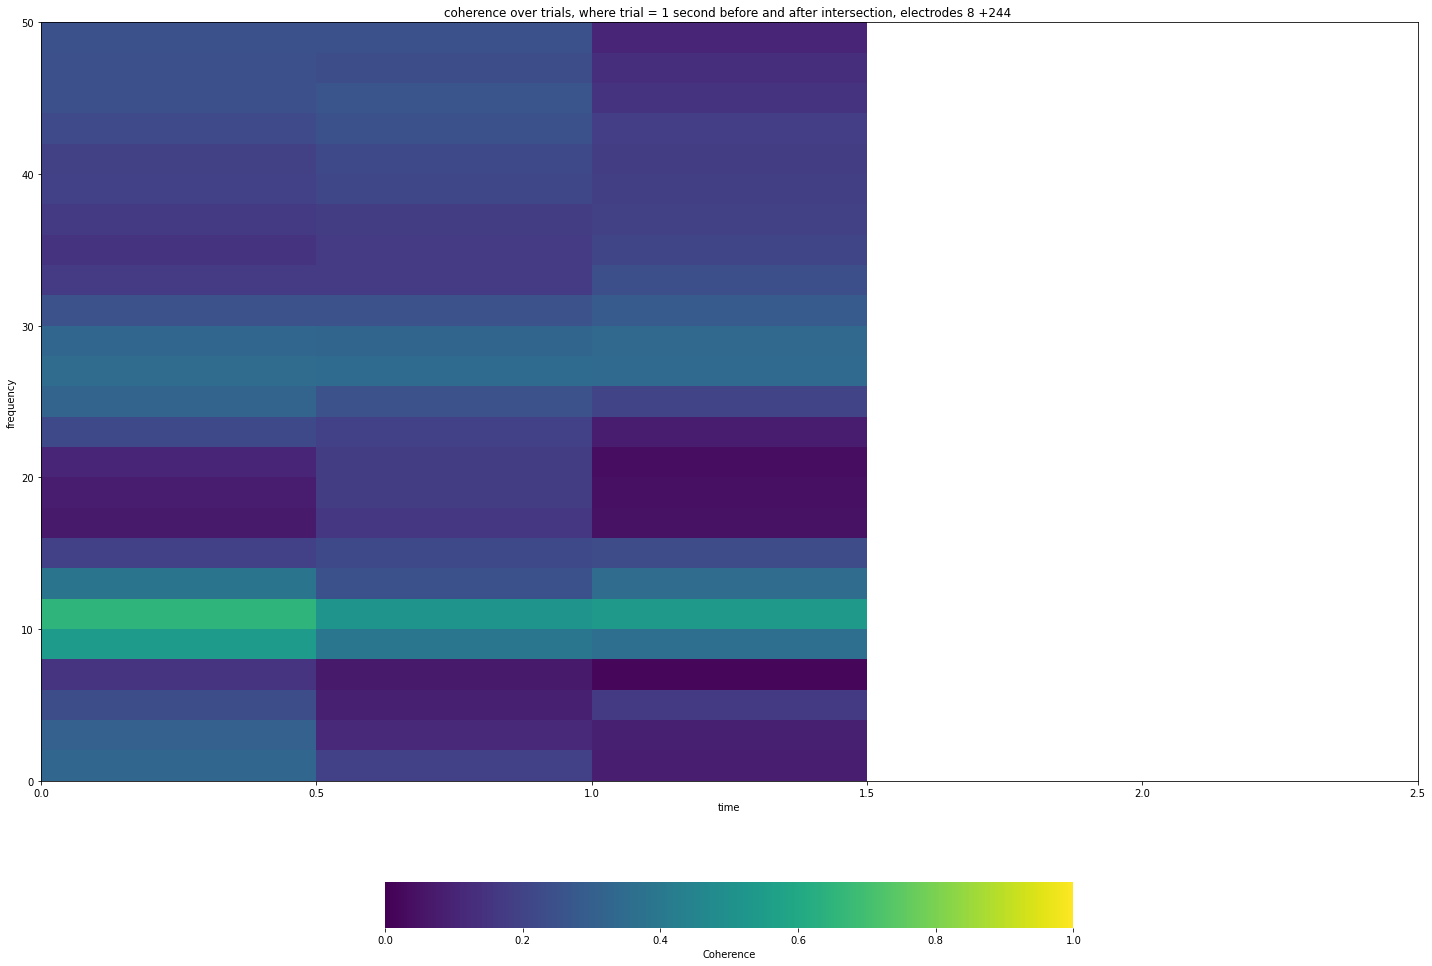

In [440]:
sampling_frequency=1000
time_halfbandwidth_product=1.5
time_window_duration=.5
time_window_step=None



m = Multitaper(signal,
               sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=time_halfbandwidth_product,
               time_window_duration=time_window_duration,
               time_window_step=time_window_step)
               # start_time=time_data[0])
c = Connectivity(fourier_coefficients=m.fft(),
                 frequencies=m.frequencies,
                 time=m.time)
time_grid, freq_grid = np.meshgrid(
    np.append(c.time, c.time[-1]),
    np.append(c.frequencies, m.nyquist_frequency))

plt.figure(figsize=(20,15))
mesh = plt.pcolormesh(time_grid,freq_grid , c.coherence_magnitude()[..., 0, 1].squeeze().T,
                             vmin=0.0, vmax=1.0, cmap='viridis')
plt.ylabel('frequency')
plt.xlabel('time')
plt.ylim(0,50)
# plt.xlim(time_data[0],time_data[-1])
plt.title(f'coherence over trials, where trial = 1 second before and after intersection, electrodes {electrode_id[electrode_ix1]} +{electrode_id[electrode_ix2]} ')
plt.xlim(0,2.5)

plt.tight_layout()
cb = plt.colorbar(mesh, orientation='horizontal',
                  shrink=.5, aspect=15, pad=0.1, label='Coherence')
# cb = plt.colorbar(mesh, ax.ravel().tolist(), orientation='horizontal',
#                   shrink=.5, aspect=15, pad=0.1, label='Coherence')
cb.outline.set_linewidth(0)
cb.outline.set_linewidth(0)
print('frequency resolution: {}'.format(m.frequency_resolution))
#maybe about two minutes

Text(0, 0.5, 'coherence')

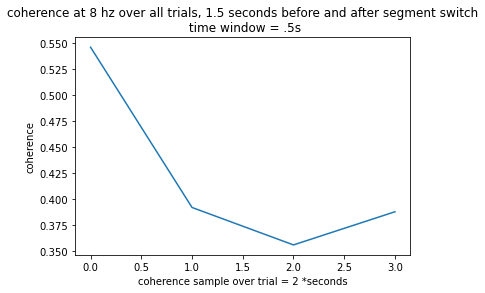

In [441]:
c.frequencies
freq_seg = c.frequencies[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coh_seg = c.coherence_magnitude()[..., 0, 1].squeeze().T[(c.frequencies == 8)]# & (c.frequencies <=9.5)]
coherency = c.coherency()[:, (c.frequencies == 8), 0, 1].squeeze()
coherency
plt.plot(coh_seg[0])
plt.title('coherence at 8 hz over all trials, 1.5 seconds before and after segment switch\n time window = .5s')
plt.xlabel('coherence sample over trial = 2 *seconds')
plt.ylabel('coherence')

#check the speed
#theta power

In [418]:
len(times)

193

In [444]:
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.604079e+09,96.2465,68.4265,1.892547,-18.510226,39.833951,43.924618
1.604079e+09,96.1395,70.3525,1.783228,-13.011806,39.301131,41.399107
1.604079e+09,96.1930,72.3320,1.723446,-8.684986,37.011240,38.016587


Text(0.5, 1.0, 'for trials im using for my coehrence calculation, what is his position?')

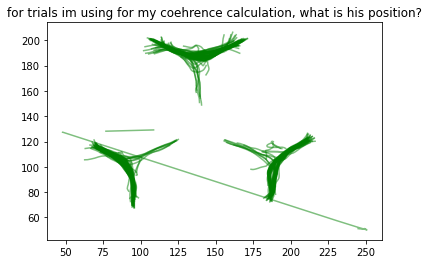

In [502]:
for ix in range(0,len(times)): 
    time_start = times[ix]-.5
    time_end = times[ix]+.5
    x_pos,y_pos = get_pos_timestamp(time_start,time_end,position_info)
    plt.plot(x_pos,y_pos, color= 'g',alpha=.5)
    
plt.title('for trials im using for my coehrence calculation, what is his position?')

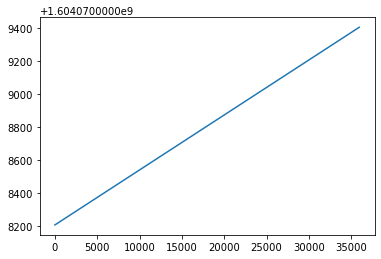

In [454]:
# plt.plot(position_info.head_position_x,position_info.head_position_y)
plt.plot(position_info.index)
plt.plot(times)

In [455]:
position_start_timestamp = (linear_position_df.index>time_start)
position_end_timestamps = (linear_position_df.index<time_end)
position_x = linear_position_df.projected_x_position[position_start_timestamp & position_end_timestamps]
position_y = linear_position_df.projected_y_position[position_start_timestamp & position_end_timestamps]

In [456]:
for ix in range(len(times)):
    time_start = times[ix]
    pos_x = position_info[position_info.index >= times[2]]
    pos_y = 

Series([], Name: projected_x_position, dtype: float64)